<a href="https://colab.research.google.com/github/alhussad/flash/blob/master/nsl_kdd_explorations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NSL-KDD dataset Exploration

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# module imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Data extraction

In [3]:
# fetch the training file
file_path_20_percent = '/content/gdrive/My Drive/Dissertation/Codes/KDDTrain+_20Percent.txt'
file_path_full_training_set = '/content/gdrive/My Drive/Dissertation/Codes/KDDTrain+.txt'
file_path_test = '/content/gdrive/My Drive/Dissertation/Codes/KDDTest+.txt' 

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

In [ ]:
#training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

Adding Column names

In [4]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [5]:
df.attack.value_counts()
# df.attack.nunique()

normal             67342
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64

# Data transformations
The first transformations that we'll want to do are around the attack field. We'll start by adding a column that encodes 'normal' values as 0 and any other value as 1. We will use this as our classifier for a simple binary model that idenfities any attack. 

In [6]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


Next, we'll classify each of the attacks according to attack type for a more granular prediction model. 
* Denial of Service attacks:
  * apache2
  * back
  * land
  * neptune
  * mailbomb
  * pod
  * processtable
  * smurf
  * teardrop
  * udpstorm
  * worm
* Probe attacks:
  * ipsweep
  * mscan
  * nmap
  * portsweep
  * saint
  * satan
* Privilege escalation attacks
  * buffer_overflow
  * loadmdoule
  * perl
  * ps
  * rootkit
  * sqlattack
  * xterm
* Remote access attacks
  * ftp_write
  * guess_passwd
  * http_tunnel
  * imap
  * multihop
  * named
  * phf
  * sendmail
  * snmpgetattack
  * snmpguess
  * spy
  * warezclient
  * warezmaster
  * xclock
  * xsnoop

In [7]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0
        
    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


# Data profiling
Some intital investigations of what we have in the set. First is a simple table of attack by protocol. In network traffic analysis protocol is a simple tool to create some initial buckets to categorize our data. 'normal' is left in the set at this point as a benchmark.

In [8]:
df.protocol_type.value_counts()

tcp     102688
udp      14993
icmp      8291
Name: protocol_type, dtype: int64

In [9]:
# use a crosstab to get attack vs protocol
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


That helps us see that most attacks are going to target a specific protocol. There are several (satan, nmap, ipsweep) that are cross-prototcol attacks

Also notice how icmp data is less frequently found in normal traffic.

Let's take a look at some charts to see how things are distributed.

In [10]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs   



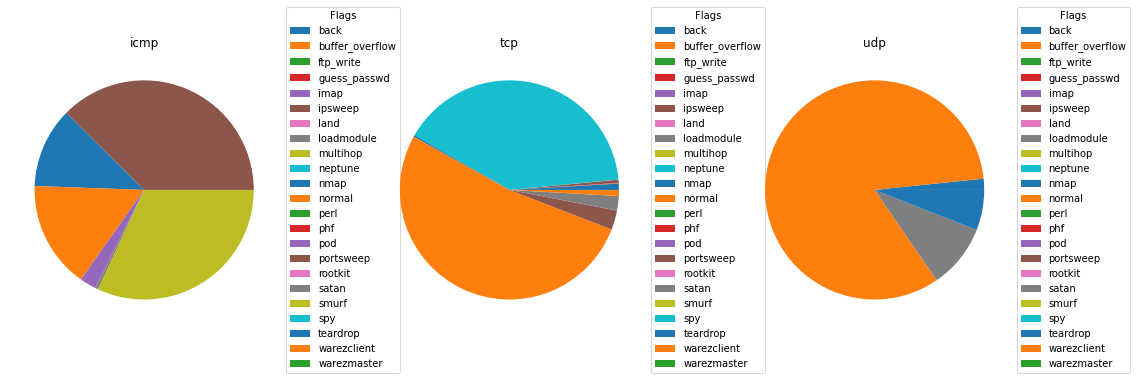

In [11]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

The thing to notice here is the difference in each protocol type. Protocol may be useful in being able to identify the type of traffic we are observing

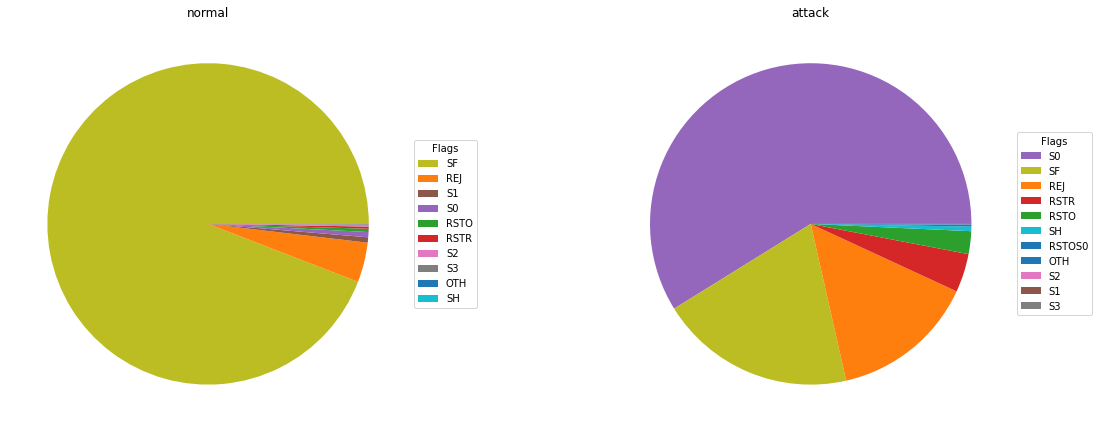

In [12]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# create the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
plt.show()

And service?

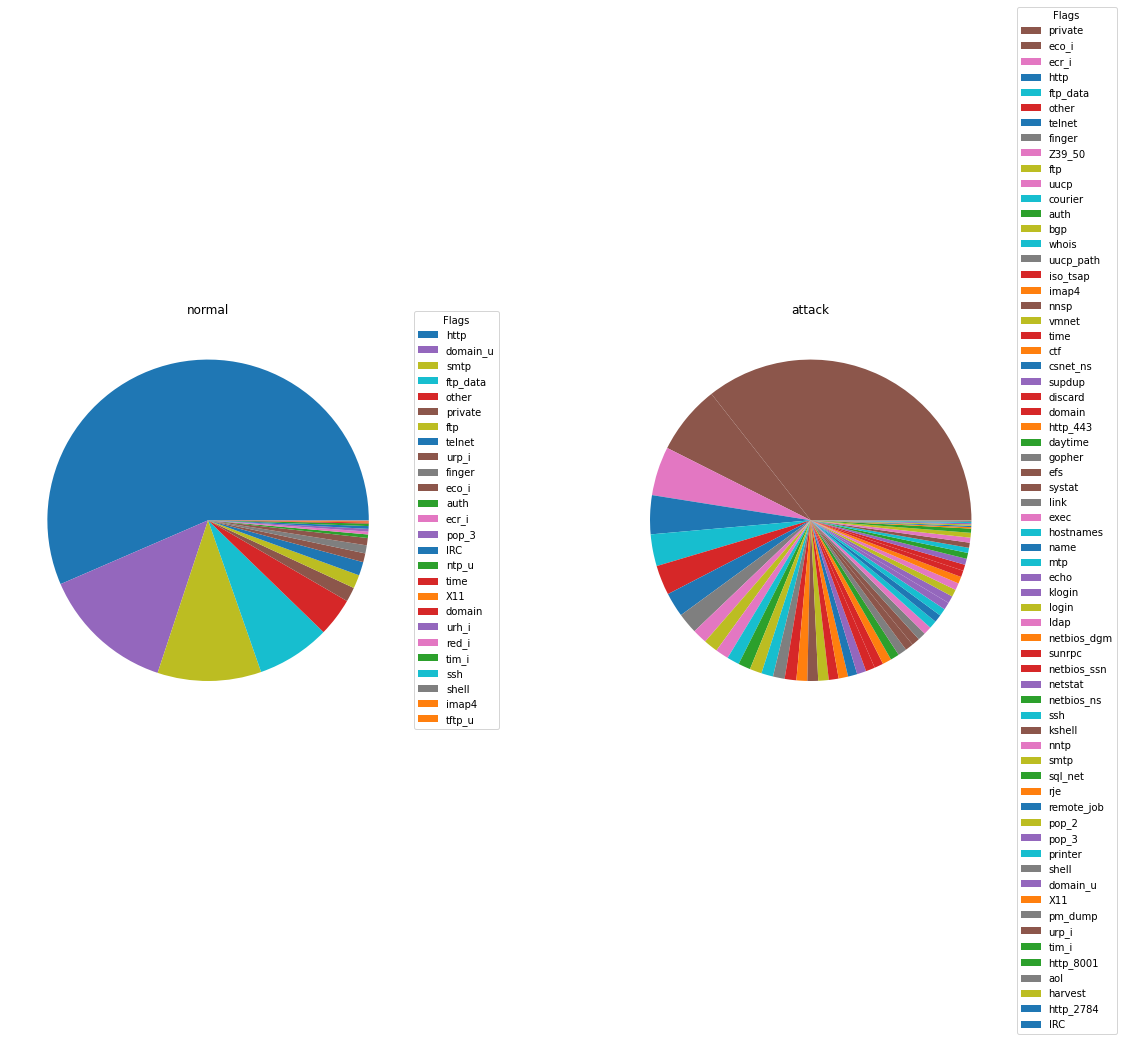

In [13]:
# get a series with the count of each service for attack and normal traffic
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normal','attack'])        
plt.show()


Look at how many services are in the attack set! Whereas a huge amount of normal traffic is http, our attack traffic is all over the place. That is interesting as it means that attacks are searching for many different paths into systems--some well traveled and some not. 

If we think about this from the eyes of a network adminstrator, the combination of protocol, flag and service seem like they should tell us a lot about the nature of our traffic. Coupling them with the duration of a connection and the amount of data in that connection seems like a good starting point for us.

# Feature engineering

So let's dive into some feature building. It seems like that items above would make a good place to start: protocol_type, service and flag. There's enough variation between these that we should be able to get some base level of identification. We're also going to throw in some basic numeric data: duration, src_bytes, dst_bytes. All of these are going to be readily available from modern network equipment and should tell us a lot about what is happening on our network.

In [14]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

It's worth drawing attention to a few things here. First, `pd.get_dummies` is a method that allows us to do a quick one hot encoding on our columns. This takes every value it finds in a single column and makes an individual column for each value, with a `0` or `1` indicating whether that column is 'hot'.

One thing we find is that note every value is in the test data. So that creates different shapes of our data frame. That's why we added some columns, filled them in and reorded them. We know they are all zeros because they aren't in the data.

Now let's go ahead and set our classification targets. We'l do both training sets to start: binrary and multi classifications.

In [15]:
# create our target classifications
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

# Model fitting
Based on the nature of the data we saw above, decision trees are a good starting point for building out predictive models. In this case we'll use a random forest to build and combine multiple trees. We'll start by simply taking the defaults.

In [16]:
# model for the binary classification
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

# calculate and display our base accuracty
base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.9932260795935648

99% accuracy on our first try! Not bad, right? Let's see how it plays out. 

It might be interesting to see how differnt models compare against a data set like this. That is easy enought to do with `cross_val_score`. 

In [17]:
# define the list of models that we want to test
models = [
    RandomForestClassifier(),
    LogisticRegression(max_iter=250),
    KNeighborsClassifier(),
]

# an empty list to capture the performance of each model
model_comps = []

# walk through the models and populate our list
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

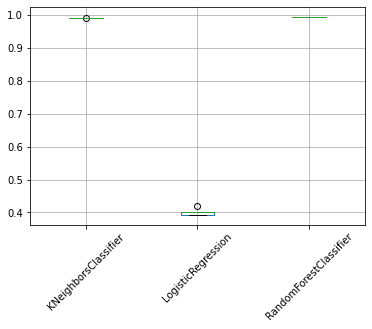

In [18]:
# a box plot will do well to show us overall performance and the variation in the models.
result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
result_df.pivot(index='count',columns='model_name',values='accuracy').boxplot(rot=45)

What we find is some inconsistency across the models. The random forest and K-nearest neighbors are tight groupings with solid performance. Our logistic regression didn't perform as well. That may be in  part because we didn't do sufficient preprocessing on our data to shape it into a form optimized for that model. That too is an exercise for another day.

# Analyzing our predictions
Let's take a look at how our predictions fared. We are going to create a helper function to pull some relevant metrics from our results. 

In [19]:
# a helper function for getting some analytical data about our predictions
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    # we need to add the predicted and actual outcomes to the data
    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'], 
                                   original_data['predicted'])
    
    # capture rows with failed predictions
    base_errors = original_data[original_data['actual'] != original_data['predicted']]
    
    # drop columns with no value
    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    # idetify the type of error
    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    # put everything into an object
    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}
    
    return prediction_data


Now we can take a closer look at our results. The first thing that we can do is look at a confusion matrix, which in this case will map the predicted classification to the actual classification.

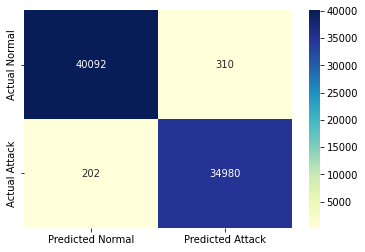

In [20]:
# capture our prediction data
binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

We see a lot of false positives (normal traffic that got flagged as an attack) and false negatives (attack traffic that got flagged as normal) there.  

So let's explore the prediction errors a bit and see if there is more information to extract.

In [21]:
# dataframe to store incorrect classification
binary_prediction_data['errors'].describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,attack_flag,attack_map,predicted,actual
count,512.000000,5.120000e+02,512.000000,512.000000,512.0,512.000000,512.000000,512.000000,512.000000,512.000000,...,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,127.851562,4.546166e+05,1577.707031,0.009766,0.0,0.001953,0.068359,0.019531,0.080078,0.082031,...,0.055840,0.106777,0.039492,0.335566,0.362930,15.099609,0.394531,0.613281,0.605469,0.394531
std,1700.404003,9.609064e+06,28800.352318,0.098434,0.0,0.044194,0.434805,0.286024,0.271680,0.889771,...,0.177434,0.247925,0.157857,0.456080,0.468067,5.593174,0.489228,0.966594,0.489228,0.489228
min,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.010000,17.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.030000,0.042500,0.010000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000
max,35301.000000,2.172773e+08,649186.000000,1.000000,0.0,1.000000,5.000000,5.000000,1.000000,16.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000,4.000000,1.000000,1.000000


Notice there are several columns with a standard deviation of 0. That tells us that there is no additional information to glean from those columns. So we can start by dropping those. 

In [22]:
# data minus the rows with no variance
binary_prediction_data['non_zeros'].describe()

,duration,src_bytes,dst_bytes,land,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,attack_flag,attack_map,predicted,actual
count,512.000000,5.120000e+02,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,...,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,127.851562,4.546166e+05,1577.707031,0.009766,0.001953,0.068359,0.019531,0.080078,0.082031,0.011719,...,0.055840,0.106777,0.039492,0.335566,0.362930,15.099609,0.394531,0.613281,0.605469,0.394531
std,1700.404003,9.609064e+06,28800.352318,0.098434,0.044194,0.434805,0.286024,0.271680,0.889771,0.107722,...,0.177434,0.247925,0.157857,0.456080,0.468067,5.593174,0.489228,0.966594,0.489228,0.489228
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.010000,17.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.030000,0.042500,0.010000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000
max,35301.000000,2.172773e+08,649186.000000,1.000000,1.000000,5.000000,5.000000,1.000000,16.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000,4.000000,1.000000,1.000000


In [23]:
# see the standard deviation of the false positives
binary_prediction_data['false_positives'].std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


duration                         6.075456
src_bytes                       47.696771
dst_bytes                      807.015817
land                             0.126175
urgent                           0.000000
hot                              0.000000
num_failed_logins                0.000000
logged_in                        0.137991
num_compromised                  0.511166
root_shell                       0.000000
su_attempted                     0.000000
num_root                         0.721727
num_file_creations               0.000000
num_shells                       0.000000
num_access_files                 0.000000
is_guest_login                   0.000000
count                            1.899214
srv_count                        3.996947
serror_rate                      0.320797
srv_serror_rate                  0.313866
rerror_rate                      0.419041
srv_rerror_rate                  0.413109
same_srv_rate                    0.055648
diff_srv_rate                    0

Now we should see some variance across our features. Here, though, we're going to look into our false positives and false negatives separately and see what we notice.

In [24]:
# see the standard deviation of the false negatives
binary_prediction_data['false_negatives'].std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


duration                       2.699511e+03
src_bytes                      1.529484e+07
dst_bytes                      4.581777e+04
land                           0.000000e+00
urgent                         7.035975e-02
hot                            6.799753e-01
num_failed_logins              4.544142e-01
logged_in                      3.794185e-01
num_compromised                1.264929e+00
root_shell                     1.701884e-01
su_attempted                   7.035975e-02
num_root                       1.311014e+00
num_file_creations             1.397254e+00
num_shells                     2.210534e-01
num_access_files               1.212589e-01
is_guest_login                 1.396654e-01
count                          1.260811e+02
srv_count                      6.540634e+00
serror_rate                    1.398803e-01
srv_serror_rate                1.833549e-01
rerror_rate                    4.530425e-01
srv_rerror_rate                4.739146e-01
same_srv_rate                  4

Notice in the false positives all of columns with no variance? In the false negatives, though, all the columns have some degree of variance. That suggests to us that there may be some good information in those columns because there is a difference bewteen the observations in one classification vs the other.

Let's also take a look at the false-negatives and see what types of attacks we missed.

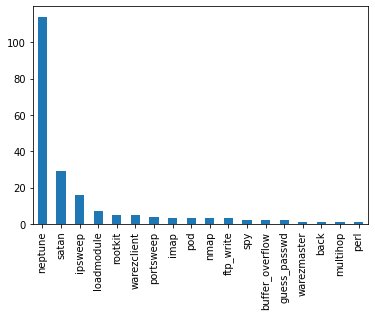

In [25]:
# distribution of false negatives--what attacks did we miss?
binary_prediction_data['false_negatives'].attack.value_counts().plot.bar()

Neptune and Satan are the biggest misses. Let's see if we can correct that.

The last data set we were working with was to_fit. So we'll work with that. Since the rest of the values are numeric features, we can add them easily.

In [26]:
# we'll need to pull these from the data set
outcomes = ['attack_flag','attack_map', 'actual']

# get the new features we're interested in and drop the outcomes
new_features = (binary_prediction_data['false_positives']==0).all(axis=0)
feature_cols = binary_prediction_data['false_positives'].loc[:,new_features]
feature_cols = feature_cols.drop(outcomes,axis=1)

# Let's get these in a list and take a look
new_feature_columns = list(feature_cols.columns)
new_feature_columns

['urgent',
 'hot',
 'num_failed_logins',
 'root_shell',
 'su_attempted',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'is_guest_login']

In [27]:
# add the new freatures
to_fit_new_features = to_fit.join(df[new_feature_columns])

# build the training sets
new_feature_train_X, new_feature_val_X, new_feature_train_y, new_feature_val_y = train_test_split(to_fit_new_features, binary_y)

Now, let's see how we performed.

In [28]:
# model for the binary classification
new_feature_model = RandomForestClassifier()
new_feature_model.fit(new_feature_train_X, new_feature_train_y)
new_feature_predictions = new_feature_model.predict(new_feature_val_X)

# get the score for the model
new_feature_score = accuracy_score(new_feature_predictions,new_feature_val_y)

new_feature_score

0.9939034071063411

We'll run another confustion matrix to see our missed predictions...

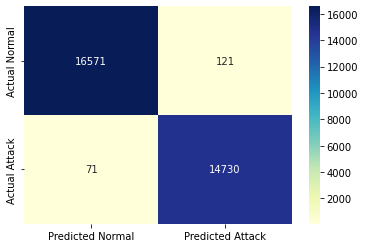

In [29]:
# capture the prediction data
new_prediction_data = add_predictions(df,
                                      new_feature_predictions,
                                      new_feature_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=new_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

That's looking better! Still a few that we missed. How about specific attacks?

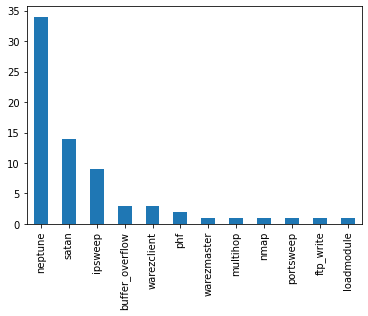

In [30]:
# distribuition of the false negatives--what attacks did we miss?
new_prediction_data['false_negatives'].attack.value_counts().plot.bar()

Overall, things are looking better. We're just missing a few isolated instances of most specific attacks. Neptune is still the hardest to find.

Now it's time to for the real thing. Let's run our model against some unseen data. We can think of this as new network traffic.

We will fit our model on full dataset and then run it against the test set to see how we did. 

In [31]:
# model for the binary classification
full_model = RandomForestClassifier(random_state=1)
full_model.fit(to_fit, binary_y)
full_predictions = full_model.predict(test_set)

# get the score
full_score = accuracy_score(full_predictions,test_binary_y)
full_score

0.8035753892560884

Wait, what!? Weren't we running 99%+ with our model? What happened? Let's look at our confusion matrix.

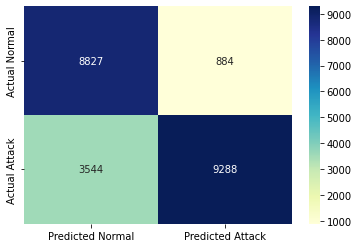

In [32]:
# capture the prediction data
full_prediction_data = add_predictions(test_df, full_predictions, test_binary_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=full_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [33]:
# create our label encoder
label_encoder = LabelEncoder()

# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'flag']
dummy_encoded = pd.get_dummies(df[features_to_encode])
test_dummy_encoded = pd.get_dummies(test_df[features_to_encode])

# now we'll label encode the service column
label_encoder.fit(df.service)
dummy_encoded['service'] = label_encoder.transform(df.service)
test_dummy_encoded['service'] = label_encoder.transform(test_df.service)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = dummy_encoded.join(df[numeric_features])
test_set = test_dummy_encoded.join(test_df[numeric_features])

# make sure our columns match
print(to_fit.columns)
print(test_set.columns)

Index(['protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp',
       'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH',
       'service', 'duration', 'src_bytes', 'dst_bytes'],
      dtype='object')
Index(['protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp',
       'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH',
       'service', 'duration', 'src_bytes', 'dst_bytes'],
      dtype='object')


In [34]:
# model for the binary classification
full_model = RandomForestClassifier(random_state=1)
full_model.fit(to_fit, binary_y)
full_predictions = full_model.predict(test_set)

# get the score
full_score = accuracy_score(full_predictions,test_binary_y)
full_score

0.7955462893137559

Let's try it with the additional features.

In [35]:
# add new features
to_fit_new_features = to_fit.join(df[new_feature_columns])
test_set_new_features = test_set.join(test_df[new_feature_columns])

In [36]:
# run the model
full_model.fit(to_fit_new_features,binary_y)
full_predictions = full_model.predict(test_set_new_features)

# get the score
full_score = accuracy_score(full_predictions,test_binary_y)
full_score

0.8042407842789336

In [37]:
# model for the mulit classification
multi_model = RandomForestClassifier()
multi_model.fit(multi_train_X, multi_train_y)
multi_predictions = multi_model.predict(multi_val_X)

# get the score
accuracy_score(multi_predictions,multi_val_y)

0.977071867061812

Now let's add the new features.

In [38]:
# build the training sets
multi_feature_train_X, multi_feature_val_X, multi_feature_train_y, multi_feature_val_y = train_test_split(to_fit_new_features, multi_y)

In [39]:
# model for the mulit classification
multi_model = RandomForestClassifier()
multi_model.fit(multi_feature_train_X, multi_feature_train_y)
multi_predictions = multi_model.predict(multi_feature_val_X)

# get the score
accuracy_score(multi_predictions,multi_feature_val_y)

0.9769155050328644

Again--strong ability to identify the attack types based on the data coming through. A quick dive into some specifics of the performance.

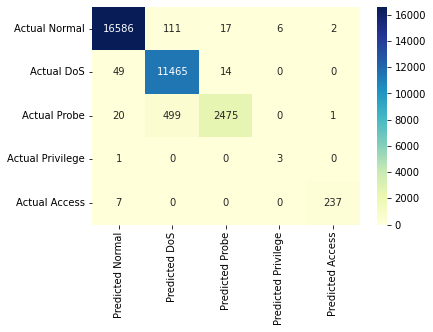

In [40]:
# capture the prediction data
multi_prediction_data = add_predictions(df, multi_predictions, multi_feature_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=multi_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted ' + x for x in attack_labels],
            yticklabels = ['Actual ' + x for x in attack_labels],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

What about the full data set are we going to see the same overfitting?

In [41]:
# fit on the full data set
multi_model.fit(to_fit_new_features, multi_y)
full_multi_predictions = multi_model.predict(test_set_new_features)

# get the score
accuracy_score(full_multi_predictions,test_multi_y)

0.7704830767865857

some significant over fitting. What if we use our smaller `to_fit` object with less features?

In [42]:
# run the model on the smaller column set
multi_model.fit(to_fit, multi_y)
full_multi_predictions = multi_model.predict(test_set)

# get the score
accuracy_score(full_multi_predictions,test_multi_y)

0.7580623696934747

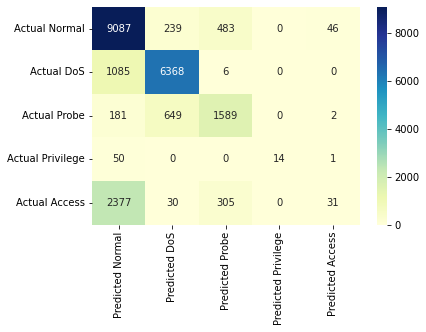

In [43]:
# build our prediction data
multi_prediction_data = add_predictions(df, full_multi_predictions, test_multi_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=multi_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted ' + x for x in attack_labels],
            yticklabels = ['Actual ' + x for x in attack_labels],
            cmap="YlGnBu",
            fmt='d',
            annot=True)